# Nutrition5k Dataset
https://github.com/google-research-datasets/Nutrition5k

In [ ]:
# Check the gpu
!nvidia-smi

Sun Jun 29 12:46:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf
import os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE
GOOGLE_BUCKET_DOMAIN = "https://storage.googleapis.com/"
DISH_IMAGES_DIRECTORY = "nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/"

## Dish Metadata
The dish metadata CSVs (metadata/dish_metadata_cafe1.csv and metadata/dish_metadata_cafe2.csv) contain all nutrition metadata at the dish-level, as well as per-ingredient mass and macronutrients.


In [ ]:
import pandas as pd
import tensorflow as tf

CSV_PATH = 'gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'
with tf.io.gfile.GFile(CSV_PATH, 'r') as f:          # fișierul rămâne în GCS
    labels = pd.read_csv(
        f,
        sep=',',
        header=None,
        usecols=range(0, 6),
        names=['dish_id', 'total_calories', 'total_mass',
               'total_fat', 'total_carb', 'total_protein']
    )

print(labels.head())

           dish_id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216      300.794281       193.0  12.387489   28.218290   
1  dish_1562688426      137.569992        88.0   8.256000    5.190000   
2  dish_1561662054      419.438782       292.0  23.838249   26.351543   
3  dish_1562008979      382.936646       290.0  22.224644   10.173570   
4  dish_1560455030       20.590000       103.0   0.148000    4.625000   

   total_protein  
0      18.633970  
1      10.297000  
2      25.910593  
3      35.345387  
4       0.956000  


In [ ]:
import pandas as pd
import tensorflow as tf

csv_path = "gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv"

with tf.io.gfile.GFile(csv_path, 'r') as f:
    labels2 = pd.read_csv(
        f,
        sep=',',
        header=None,
        usecols=range(6),
        names=['dish_id', 'total_calories', 'total_mass',
               'total_fat', 'total_carb', 'total_protein']
    )

labels2.head()

dish_id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1572974428             0.0        74.0        0.0         0.0   
1  dish_1572464692             0.0        56.0        0.0         0.0   
2  dish_1571931594             0.0        66.0        0.0         0.0   
3  dish_1575478635             0.0       132.0        0.0         0.0   
4  dish_1572887017             0.0       274.0        0.0         0.0   

   total_protein  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

# EDA

In [ ]:
full_labels_df = pd.concat([labels, labels2], axis=0, ignore_index=True)
full_labels_df.head()

dish_id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216      300.794281       193.0  12.387489   28.218290   
1  dish_1562688426      137.569992        88.0   8.256000    5.190000   
2  dish_1561662054      419.438782       292.0  23.838249   26.351543   
3  dish_1562008979      382.936646       290.0  22.224644   10.173570   
4  dish_1560455030       20.590000       103.0   0.148000    4.625000   

   total_protein  
0      18.633970  
1      10.297000  
2      25.910593  
3      35.345387  
4       0.956000

In [ ]:
labels.shape, labels2.shape

((4768, 6), (238, 6))

In [ ]:
full_labels_df.sort_values(by='total_calories').head(10)

dish_id  total_calories  total_mass  total_fat  total_carb  \
4801  dish_1572031580             0.0        90.0        0.0         0.0   
4786  dish_1572453701             0.0        85.0        0.0         0.0   
4787  dish_1572291671             0.0       108.0        0.0         0.0   
4788  dish_1573072410             0.0       139.0        0.0         0.0   
4789  dish_1572540876             0.0        65.0        0.0         0.0   
4790  dish_1572464738             0.0       188.0        0.0         0.0   
4791  dish_1571945939             0.0        97.0        0.0         0.0   
4792  dish_1573243053             0.0       132.0        0.0         0.0   
4793  dish_1571931782             0.0       104.0        0.0         0.0   
4794  dish_1574455517             0.0       192.0        0.0         0.0   

      total_protein  
4801            0.0  
4786            0.0  
4787            0.0  
4788            0.0  
4789            0.0  
4790            0.0  
4791            0.0  
4792            0.0  
4793            0.0  
4794            0.0

Observam ca in dataset  exista multe intrari cu calorii 0

In [ ]:
import tensorflow as tf

metadata_dir = "gs://nutrition5k_dataset/nutrition5k_dataset/metadata"

files = tf.io.gfile.listdir(metadata_dir)
for f in files:
    print(f)

dish_metadata_cafe1.csv
dish_metadata_cafe2.csv
ingredients_metadata.csv


In [ ]:
#Step 2: Download image corresponding to dish_id

#create url from dish_id
#specify rbg (normal photo), depth_raw, and depth_colored image of the dish
def create_image_url(dish_id, image_type='overhead_depth_rgb'):

  file = ''
  if image_type == "overhead_rgb":
    file = 'rgb.png'
  elif image_type == "overhead_depth_color":
    file = 'depth_color.png'
  elif image_type == "overhead_depth_raw":
    file = 'depth_raw.png'
  else:
    raise ValueError('create_image_url() image_type parameter passed not valid')

  url = GOOGLE_BUCKET_DOMAIN + DISH_IMAGES_DIRECTORY + dish_id + '/' + file

  return url

#preview purposes - download image given url
def view_image(url: str):
  #IPython.display.Image(url, width = 250)
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

test url:  https://storage.googleapis.com/nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1572974428/rgb.png


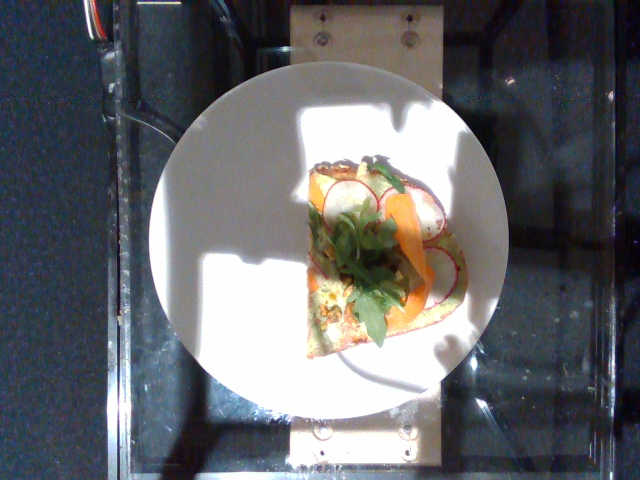

In [ ]:

#test create_image_url function
test_url = create_image_url('dish_1572974428', "overhead_rgb")
print("test url: ", test_url)
#preview image
test_image = view_image(test_url)
test_image

#Note: @TODO this dish allegedly has 0 calories. Even if mostly veggies, still looks like it should have some

test url:  https://storage.googleapis.com/nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1574359199/rgb.png


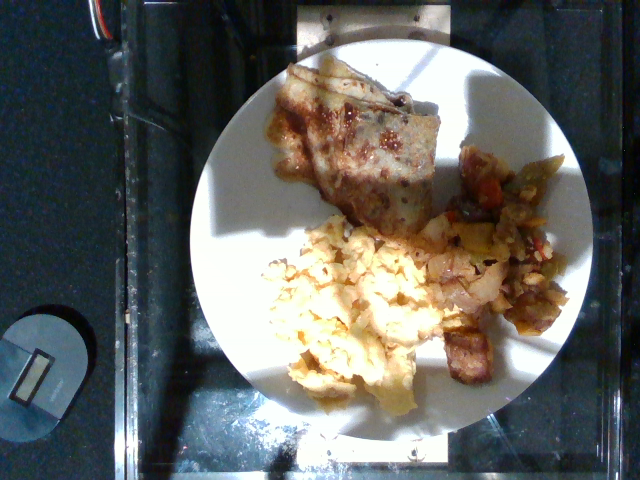

In [ ]:
#test create_image_url function
test_url = create_image_url('dish_1574359199', "overhead_rgb")
print("test url: ", test_url)
#preview image
test_image = view_image(test_url)
test_image

In [ ]:
#exclude bad entires from dataset
print("Total entries with 0 calories: ", full_labels_df[full_labels_df['total_calories']==0].shape[0])
print("Total entries in dataset: ", full_labels_df.shape[0])
print('Total good label entries in csv: ', full_labels_df.shape[0] - full_labels_df[full_labels_df['total_calories']==0].shape[0])

Total entries with 0 calories:  240
Total entries in dataset:  5006
Total good label entries in csv:  4766


* In total sunt 5006 dish-uri in dataset
* Sunt 240 intrari cu 0 calorii, le consider gresite si trebuie scoase
*  Raman 4766 dish-uri in dataset

In [ ]:
issue_dish_id_array = full_labels_df[full_labels_df['total_calories']==0].dish_id.values

len(issue_dish_id_array)

240

In [ ]:
full_labels_df['dish_id'].is_unique

True

In [ ]:
full_labels_df[full_labels_df['total_calories']!=0].describe()

total_calories   total_mass    total_fat   total_carb  total_protein
count     4766.000000  4766.000000  4766.000000  4766.000000    4766.000000
mean       224.074826   191.491817    11.261491    17.859201      15.205472
std        312.615468   275.086565    24.942476    29.132718      18.729645
min          1.150000     5.000000     0.000000     0.000000       0.072000
25%         60.992498    72.000000     0.621500     5.129467       1.684543
50%        154.337662   145.000000     6.485808    12.718711       8.259263
75%        324.397980   260.000000    16.069001    24.200296      22.528633
max       9485.815430  7975.000000   875.541016   844.568604     147.491821

In [ ]:
corrected_full_df = full_labels_df[full_labels_df['total_calories']!=0]
min_dish_id = corrected_full_df[corrected_full_df['total_calories'] == corrected_full_df['total_calories'].min()].dish_id.item()
print("dish with lowest calories: ", min_dish_id)
corrected_full_df[corrected_full_df['total_calories'] == corrected_full_df['total_calories'].min()]

dish with lowest calories:  dish_1558461431


dish_id  total_calories  total_mass  total_fat  total_carb  \
287  dish_1558461431            1.15         5.0       0.02        0.18   

     total_protein  
287          0.145

# EDA pentru metadate

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
corrected_full_df.shape

(4766, 6)

In [ ]:
corrected_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4766 entries, 0 to 4767
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         4766 non-null   object 
 1   total_calories  4766 non-null   float64
 2   total_mass      4766 non-null   float64
 3   total_fat       4766 non-null   float64
 4   total_carb      4766 non-null   float64
 5   total_protein   4766 non-null   float64
dtypes: float64(5), object(1)
memory usage: 260.6+ KB


In [ ]:
corrected_full_df.describe()

total_calories   total_mass    total_fat   total_carb  total_protein
count     4766.000000  4766.000000  4766.000000  4766.000000    4766.000000
mean       224.074826   191.491817    11.261491    17.859201      15.205472
std        312.615468   275.086565    24.942476    29.132718      18.729645
min          1.150000     5.000000     0.000000     0.000000       0.072000
25%         60.992498    72.000000     0.621500     5.129467       1.684543
50%        154.337662   145.000000     6.485808    12.718711       8.259263
75%        324.397980   260.000000    16.069001    24.200296      22.528633
max       9485.815430  7975.000000   875.541016   844.568604     147.491821

In [ ]:
def hist(column, bins, data=corrected_full_df):
    plt.figure(figsize=(10, 7))
    plt.title(f'Histogram for {column}')

    if bins:
        sns.histplot(x=column, data=data, bins=bins)
    else:
        sns.histplot(x=column, data=data)

    # Calculează statisticile
    mean_val = data[column].mean()
    median_val = data[column].median()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    # Linii verticale
    plt.axvline(x=mean_val, color='orange', linestyle='--', label='Mean')
    plt.axvline(x=median_val, color='red', linestyle='-', label='Median')
    plt.axvline(x=upper_bound, color='blue', linestyle='--', label='Upper Bound')

    # Texte explicative (poziționate puțin mai sus pe axa Y)
    plt.text(mean_val, plt.ylim()[1]*0.9, f'Mean\n{mean_val:.1f}', color='orange', ha='center')
    plt.text(median_val, plt.ylim()[1]*0.8, f'Median\n{median_val:.1f}', color='red', ha='center')
    plt.text(upper_bound, plt.ylim()[1]*0.7, f'Upper Bound\n{upper_bound:.1f}', color='blue', ha='center')

    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
def boxplot(column, data=corrected_full_df):
  plt.figure(figsize=(5,1))
  plt.title(f'Boxplot for {column}')

  sns.boxplot(data=data, x=column)
  plt.show()

## Analiza pentru total_calories

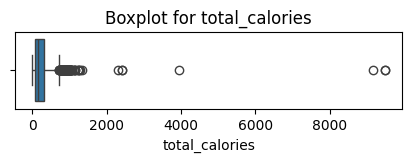

In [ ]:
boxplot('total_calories')

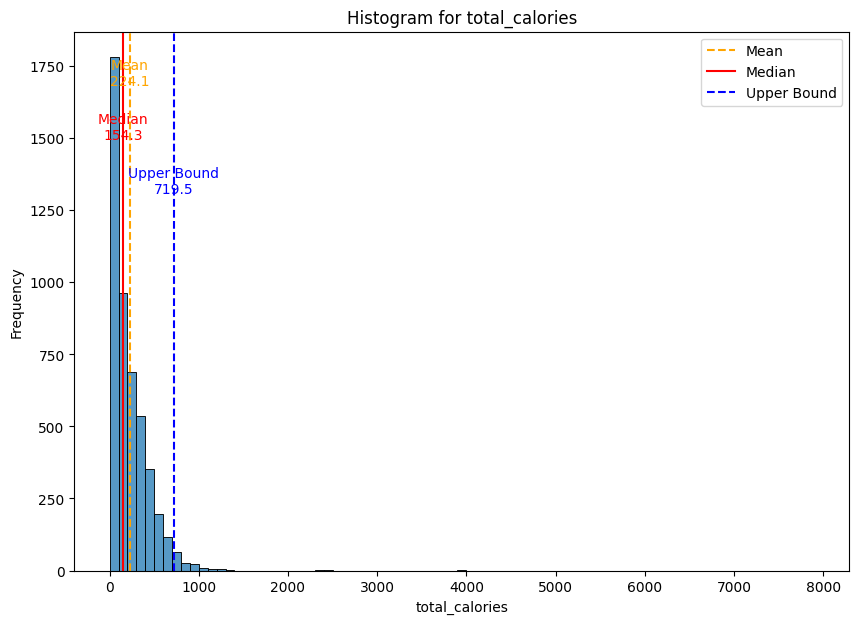

In [ ]:
hist('total_calories',bins=range(0,8000,100))

### Analizam outliers pentru total_calories



In [ ]:
# vizualizam outlierii principali. Prima data cu mai mult de 8000 de calorii
outliers_cal = corrected_full_df[corrected_full_df['total_calories']>8000]
outliers_cal

dish_id  total_calories  total_mass   total_fat  total_carb  \
446   dish_1551567573     9485.815430       159.0  875.541016  506.078979   
565   dish_1551567604     9485.815430       159.0  875.541016  506.079010   
3568  dish_1551567508     9170.099609      7974.0  853.218018  502.362000   

      total_protein  
446       87.785004  
565       87.785004  
3568      63.792004

In [ ]:
# vizualizam OUTLIERII dintre 3000 si 5000 de calorii
corrected_full_df[(corrected_full_df['total_calories']<5000)&(corrected_full_df['total_calories']>3000)]

dish_id  total_calories  total_mass  total_fat  total_carb  \
2213  dish_1560974769     3943.325195      3051.0  10.976549  844.568604   

      total_protein  
2213      83.749603

## Analiza pentru total_mass

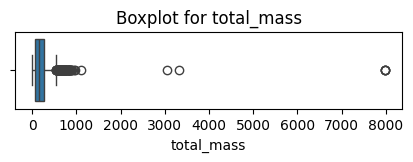

In [ ]:
boxplot('total_mass')

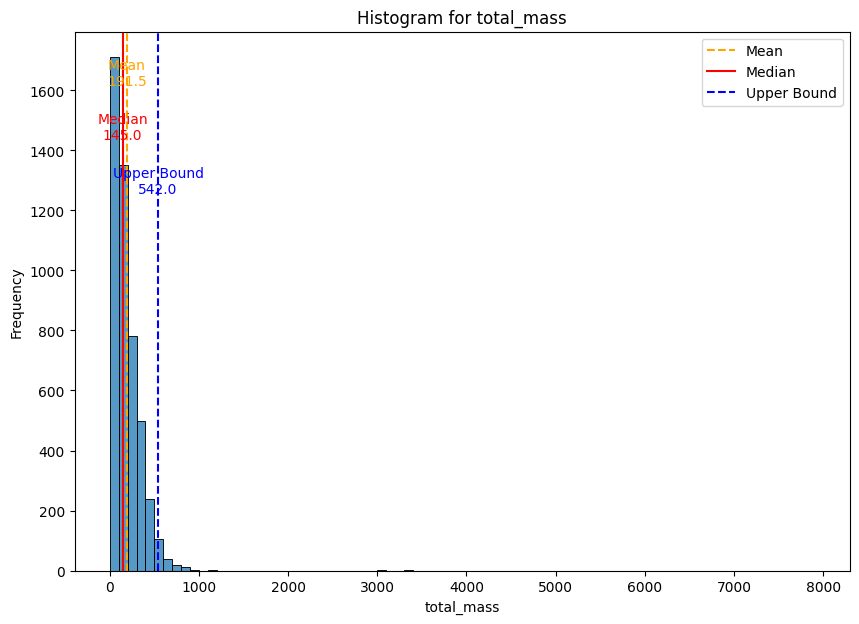

In [ ]:
hist('total_mass',bins=range(0,8000,100))

In [ ]:
outliers_mass=corrected_full_df[corrected_full_df['total_mass']>6000]
outliers_mass

dish_id  total_calories  total_mass   total_fat  total_carb  \
2538  dish_1551232973      107.599998      7975.0    1.393000   20.700001   
2548  dish_1551138237      138.938004      7974.0    1.692000   27.547001   
3568  dish_1551567508     9170.099609      7974.0  853.218018  502.362000   
4218  dish_1551389458     2312.459961      7974.0   23.922001  717.660034   

      total_protein  
2538       4.993000  
2548       4.559000  
3568      63.792004  
4218      87.713997

## Analiza pentru total_fat

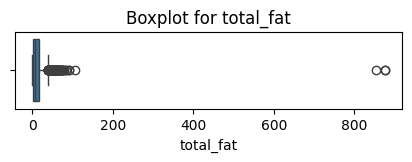

In [ ]:
boxplot('total_fat')

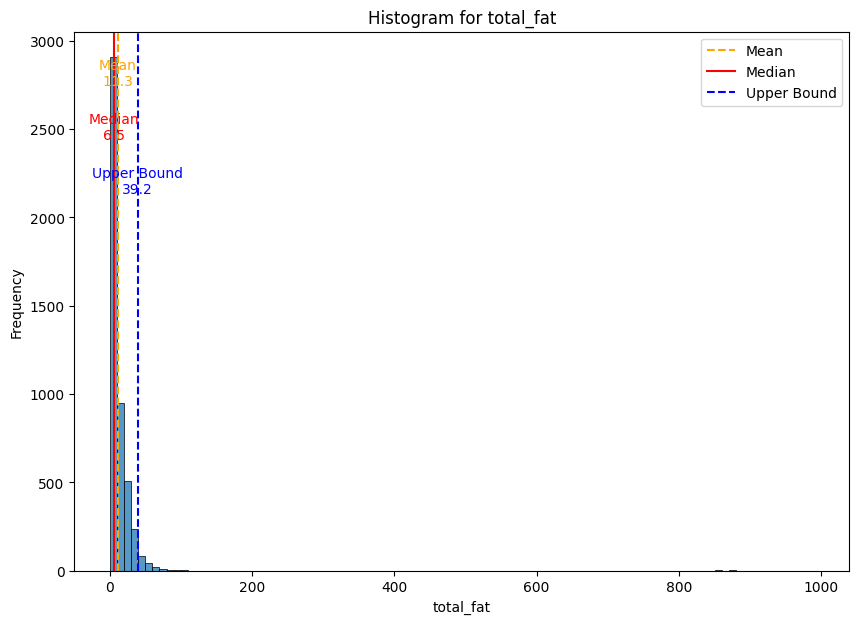

In [ ]:
hist('total_fat',bins=range(0,1000,10))

In [ ]:
outliers_fat = corrected_full_df[corrected_full_df['total_fat']>600]
outliers_fat

dish_id  total_calories  total_mass   total_fat  total_carb  \
446   dish_1551567573     9485.815430       159.0  875.541016  506.078979   
565   dish_1551567604     9485.815430       159.0  875.541016  506.079010   
3568  dish_1551567508     9170.099609      7974.0  853.218018  502.362000   

      total_protein  
446       87.785004  
565       87.785004  
3568      63.792004

## Analiza pentru carbohidrati

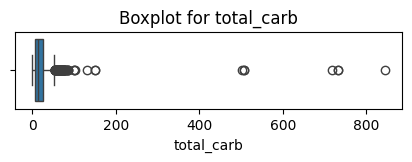

In [ ]:
boxplot('total_carb')

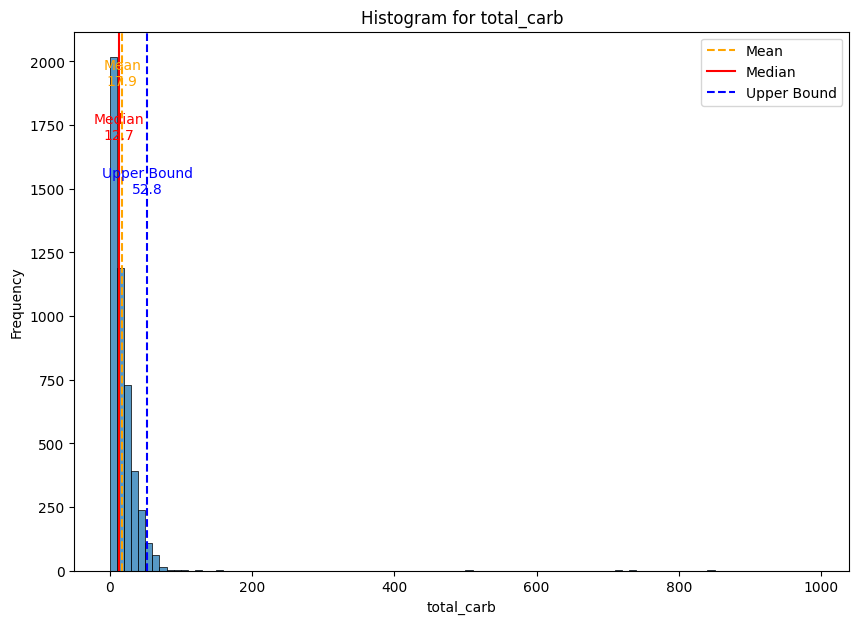

In [ ]:
hist('total_carb',bins=range(0,1000,10))

In [ ]:
outliers_carbs = corrected_full_df[corrected_full_df['total_carb']>600]
outliers_carbs

dish_id  total_calories  total_mass  total_fat  total_carb  \
995   dish_1551389588     2400.780029       133.0  27.552002  732.300049   
2213  dish_1560974769     3943.325195      3051.0  10.976549  844.568604   
2334  dish_1551389551     2400.780029       133.0  27.552002  732.300049   
4218  dish_1551389458     2312.459961      7974.0  23.922001  717.660034   

      total_protein  
995       90.181999  
2213      83.749603  
2334      90.181999  
4218      87.713997

## Analiza pentru total protein

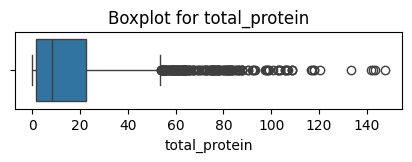

In [ ]:
boxplot('total_protein')

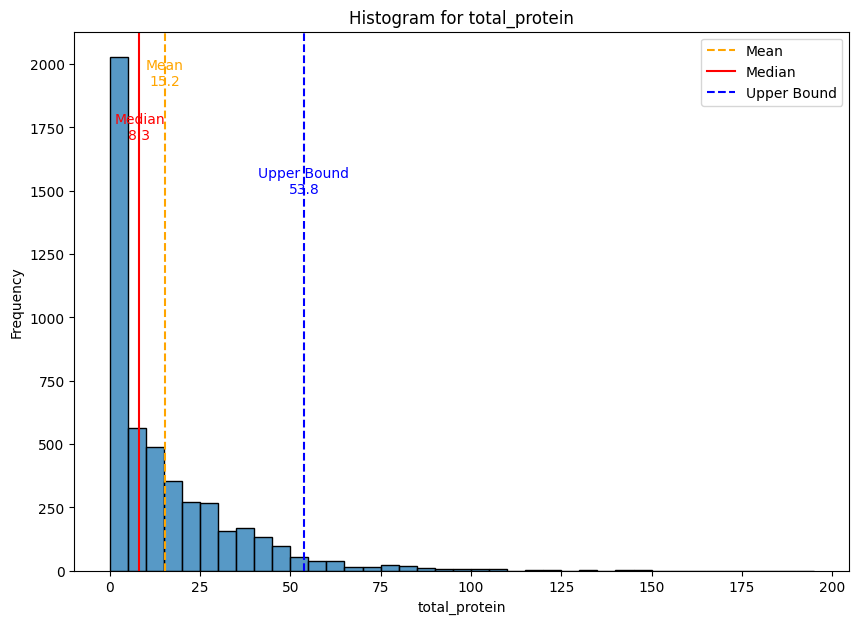

In [ ]:
hist('total_protein',bins=range(0,200,5))

# Eda pentru imagini

Imaginea cu cele mai putine calorii

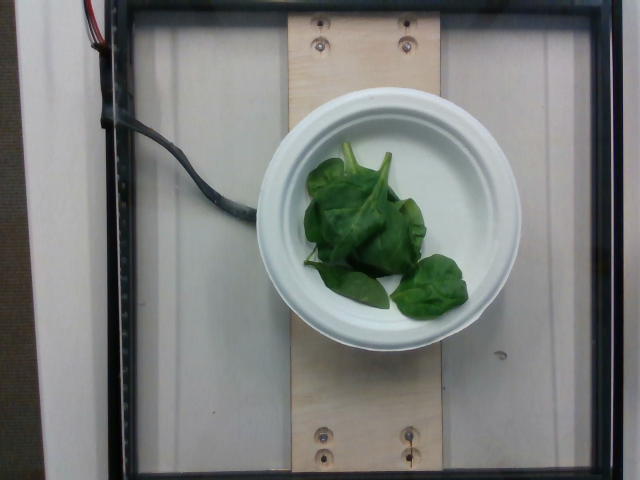

In [ ]:
#view small calorie entry
test_url = create_image_url(min_dish_id, "overhead_rgb")
#preview image
test_image = view_image(test_url)
test_image

In [ ]:
#get dish in dataset with most calories

corrected_full_df[corrected_full_df['total_calories'] == corrected_full_df['total_calories'].max()]

dish_id  total_calories  total_mass   total_fat  total_carb  \
446  dish_1551567573      9485.81543       159.0  875.541016  506.078979   
565  dish_1551567604      9485.81543       159.0  875.541016  506.079010   

     total_protein  
446      87.785004  
565      87.785004

In [ ]:
data_dir = './snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead'

#have to have preprocessed data in a Google Bucket for this to work
#ds_train, ds_test = tfds.load(name="test", split=["train", "test"], data_dir="gs://nutrition5k_dataset")

#get label for dish
def get_nutrition_from_dish_id(full_labels_df, dish_id):
    total_calories = full_labels_df[full_labels_df['dish_id']==dish_id]['total_calories'].item()
    total_mass = full_labels_df[full_labels_df['dish_id']==dish_id]['total_mass'].item()
    total_fat = full_labels_df[full_labels_df['dish_id']==dish_id]['total_fat'].item()
    total_carb = full_labels_df[full_labels_df['dish_id']==dish_id]['total_carb'].item()
    total_protein = full_labels_df[full_labels_df['dish_id']==dish_id]['total_protein'].item()

    return (total_calories, total_mass, total_fat, total_carb, total_protein)

In [ ]:
import tensorflow as tf
import pandas as pd
from pathlib import Path


GCS_ROOT = "gs://nutrition5k_dataset/nutrition5k_dataset"
DATA_DIR  = f"{GCS_ROOT}/imagery/realsense_overhead"
CSV_PATH  = f"{GCS_ROOT}/metadata/dish_metadata_cafe1.csv"


issue_dish_id_array = []


with tf.io.gfile.GFile(CSV_PATH, "r") as f:
    full_labels_df = pd.read_csv(
        f, header=None, usecols=range(6),
        names=["dish_id", "total_calories", "total_mass",
               "total_fat", "total_carb", "total_protein"]
    )


full_labels_df["dish_id"] = full_labels_df["dish_id"].astype(str)\
    .apply(lambda d: d if d.startswith("dish_") else f"dish_{d}")


dish_ids_in_csv = set(full_labels_df["dish_id"])


rgb_paths = tf.io.gfile.glob(f"{DATA_DIR}/dish_*/rgb.png")
dish_ids_with_rgb = [Path(p).parts[-2] for p in rgb_paths]


issue_set = set(issue_dish_id_array)
valid_dish_ids = [
    d for d in dish_ids_with_rgb
    if (d in dish_ids_in_csv) and (d not in issue_set)
]


def get_nutrition_from_dish_id(full_labels_df, dish_id):
    row = full_labels_df[full_labels_df["dish_id"] == dish_id]
    if row.empty:
        raise ValueError(f"{dish_id} nu există în CSV!")
    return (
        row["total_calories"].item(),
        row["total_mass"].item(),
        row["total_fat"].item(),
        row["total_carb"].item(),
        row["total_protein"].item()
    )

filenames = [f"{DATA_DIR}/{dish_id}/rgb.png" for dish_id in valid_dish_ids]
labels    = [get_nutrition_from_dish_id(full_labels_df, dish_id)
             for dish_id in valid_dish_ids]

data_dict   = {"filename": filenames, "label": labels}
image_count = len(filenames)

print("Total dish-uri cu imagini RGB găsite: ", len(dish_ids_with_rgb))
print("Dish-uri valide după filtrare:        ", image_count)
print("Exemplu:\n ", filenames[0], "\n ", labels[0])

Total dish-uri cu imagini RGB găsite:  3490
Dish-uri valide după filtrare:         3262
Exemplu:
  gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png 
  (41.399998, 36.0, 3.852, 2.268, 0.288)


S-au validat 3262 din 3490 imagini din dataset

In [ ]:
#create full dataset that will feed into tensorflow
list_ds = tf.data.Dataset.from_tensor_slices(data_dict)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

#preview paths
for f in list_ds.take(5):
  print(f['filename'].numpy())
  print(f['label'].numpy())

b'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1558031351/rgb.png'
[12.3   41.     0.041  3.116  0.246]
b'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1563897794/rgb.png'
[ 57.57  101.      0.303  14.14    0.707]
b'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1558373492/rgb.png'
[888.23  325.     66.769  42.29   38.957]
b'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1558548666/rgb.png'
[97.5   75.     0.225 21.     2.025]
b'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1563218987/rgb.png'
[383.55966  172.        19.782057  17.969845  31.66508 ]


In [ ]:
#split dataset into train and validation sets
train_ds_size = int(0.70 * image_count)
valid_ds_size = int(0.15 * image_count)

#train will be 70%
train_ds = list_ds.take(train_ds_size)
remaining = list_ds.skip(train_ds_size)
#val will be 15%
val_ds = remaining.take(valid_ds_size)
#test will be 15%
test_ds = remaining.skip(valid_ds_size)

#print length of each
print("train split length: ", tf.data.experimental.cardinality(train_ds).numpy())
print("val split length: ",tf.data.experimental.cardinality(val_ds).numpy())
print("test split length: ",tf.data.experimental.cardinality(val_ds).numpy())

# #preview train (should be same format as full list_ds)
# for f in train_ds.take(5):
#   print(f['filename'].numpy())
#   print(f['label'].numpy())

train split length:  2283
val split length:  489
test split length:  489


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  print(f"Process Path File Path: {file_path}")
  #get label
  label = file_path['label']
  #print(label)

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path['filename'])
  img = decode_img(img)
  return img, label

#Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x: process_path(x), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x: process_path(x), num_parallel_calls=AUTOTUNE)

Process Path File Path: {'filename': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_1:0' shape=(5,) dtype=float32>}
Process Path File Path: {'filename': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_1:0' shape=(5,) dtype=float32>}
Process Path File Path: {'filename': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_1:0' shape=(5,) dtype=float32>}


In [ ]:
#check one image shape
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", len(label.numpy()))

Image shape:  (180, 180, 3)
Label:  5


# Configure dataset batching and shuffling for performance

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

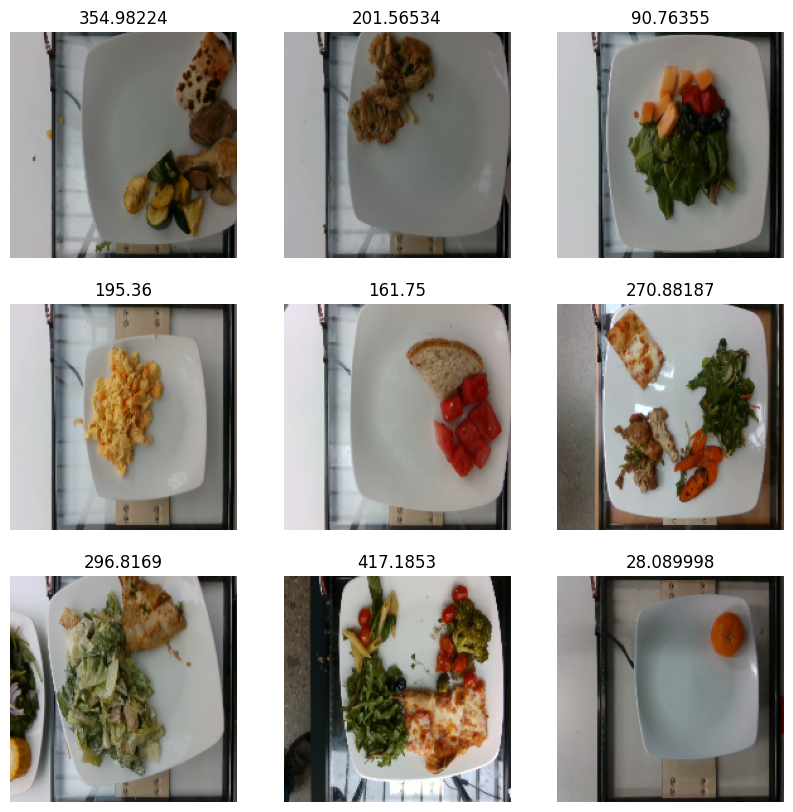

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(label.numpy()[0]) #preview calories only
  plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Base CNN Model

In [ ]:
num_macros = 5 #(total_calories, total_mass, total_fat, total_carb, total_protein)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), #rescaling here to sure so that all datasets pass through this
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_macros)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),  # cu paranteze!
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - loss: 22559.3984 - mae: 79.4217 - root_mean_squared_error: 149.4316 - val_loss: 10435.9805 - val_mae: 57.6860 - val_root_mean_squared_error: 102.1566
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11268.1123 - mae: 52.0665 - root_mean_squared_error: 106.0075 - val_loss: 7917.1279 - val_mae: 47.3974 - val_root_mean_squared_error: 88.9782
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9965.7559 - mae: 46.8992 - root_mean_squared_error: 99.5572 - val_loss: 7748.5190 - val_mae: 47.2872 - val_root_mean_squared_error: 88.0257
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9494.3291 - mae: 45.8269 - root_mean_squared_error: 97.1029 - val_loss: 7658.8896 - val_mae: 46.9054 - val_root_mean_squared_error: 87.5151
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9321.1895 - mae: 45.3700 - root_mean_squared_error: 96.1928 - val_loss: 7558.8311 - val_mae: 46.7034 - val_root_mean_squared_error: 86.9415
Epo

# Test Dataset Results

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

results = model.evaluate(test_ds, return_dict=True, verbose=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model.predict(test_ds, verbose=0)


r2 = r2_score(y_true, y_pred)

# Afișare
print(f"Test loss (MSE):         {results['loss']:.4f}")
print(f"Test RMSE (keras layer): {results['root_mean_squared_error']:.4f}")
print(f"Test MAE:                {results['mae']:.4f}")
print(f"Test R²:                 {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - loss: 6602.0254 - mae: 46.0059 - root_mean_squared_error: 81.2410
Test loss (MSE):         6818.5151
Test RMSE (keras layer): 82.5743
Test MAE:                45.7116
Test R²:                 0.3259


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1️⃣  Colectezi corect y_true & y_pred
y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model.predict(test_ds, verbose=0)

# 2️⃣  Extragi calorii
y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]

# 3️⃣  (dacă ai normalizat etichetele, denormalizează aici)

# 4️⃣  Calculezi metricile
rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 156.99,  MAE: 122.03,  R²: 0.413


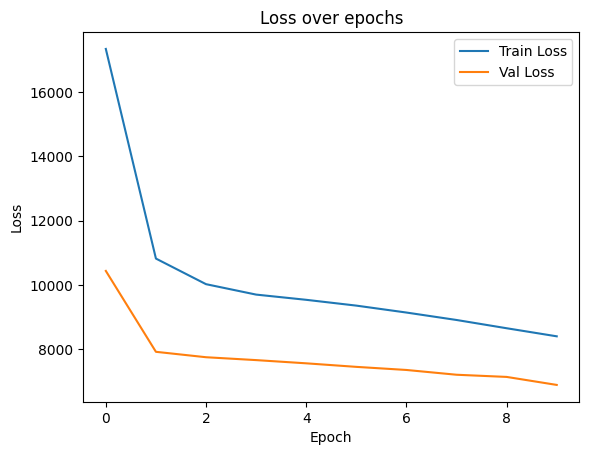

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 180, 180, 3))', 'Tensor(shape=(32, 5))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


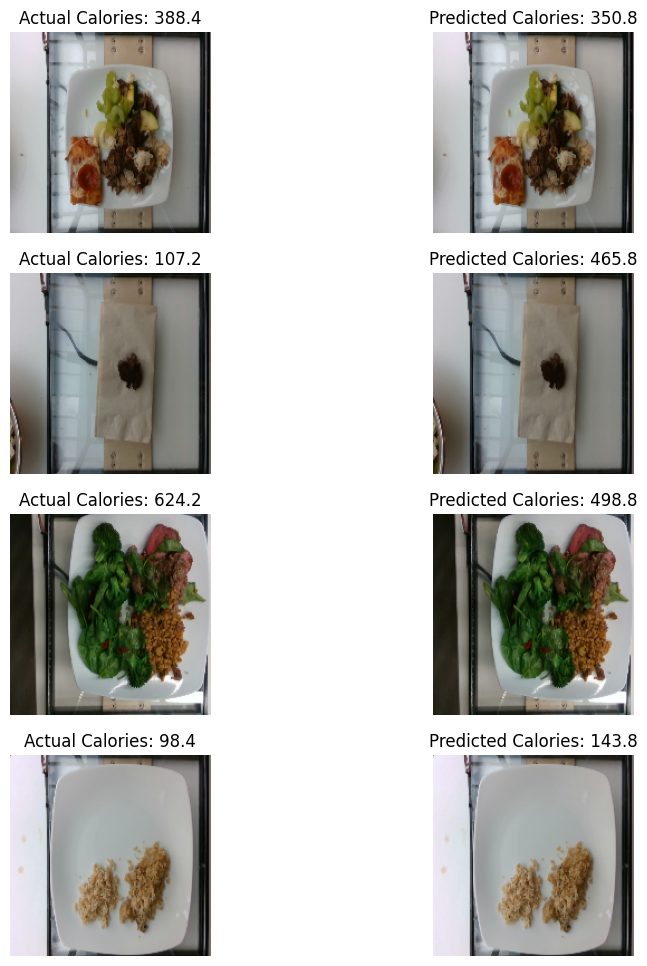

In [ ]:
#Test: show sample breakdown of actual v.s. predicted
fig, axs = plt.subplots(4, 2, figsize=(10, 12))
for ax in axs.ravel():
    ax.axis('off')

#(total_calories, total_mass, total_fat, total_carb, total_protein)
test_images = test_ds.take(4)

actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []

pred_calories = []
pred_mass = []
pred_fat = []
pred_carb = []
pred_protein = []

for i, element in enumerate(test_images):
  #actual calories
  axs[i][0].imshow(element[0][0].numpy().astype("uint8"))
  axs[i][0].set_title(f'Actual Calories: {element[1][0][0]:.1f}')
  actual_calories.append(float(element[1][0][0]))
  actual_mass.append(float(element[1][0][1]))
  actual_fat.append(float(element[1][0][2]))
  actual_carb.append(float(element[1][0][3]))
  actual_protein.append(float(element[1][0][4]))

  predicted_macros = model.predict(element)
  predicted_calories = predicted_macros[1][0]
  axs[i][1].imshow(element[0][0].numpy().astype("uint8"))
  axs[i][1].set_title(f'Predicted Calories: {predicted_calories:.1f}')
  pred_calories.append(predicted_macros[1][0])
  pred_mass.append(predicted_macros[1][1])
  pred_fat.append(predicted_macros[1][2])
  pred_carb.append(predicted_macros[1][3])
  pred_protein.append(predicted_macros[1][4])

# Antrenam pe mai multe epoci cu callback

In [ ]:
import tensorflow as tf
import os, datetime


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

chkpt_path = 'checkpoints/best_model.h5'
os.makedirs(os.path.dirname(chkpt_path), exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    chkpt_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


log_dir = os.path.join("logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

In [ ]:
num_macros = 5

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_macros)
])
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 23046.9082 - mae: 80.9466 - root_mean_squared_error: 150.9696

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 22966.8457 - mae: 80.7758 - root_mean_squared_error: 150.6982 - val_loss: 9599.1045 - val_mae: 54.6048 - val_root_mean_squared_error: 97.9750 - learning_rate: 0.0010
Epoch 2/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10802.9482 - mae: 49.9402 - root_mean_squared_error: 103.7727

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 10766.6846 - mae: 49.7486 - root_mean_squared_error: 103.6099 - val_loss: 7783.1484 - val_mae: 46.9357 - val_root_mean_squared_error: 88.2222 - learning_rate: 0.0010
Epoch 3/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9677.0654 - mae: 45.9889 - root_mean_squared_error: 98.0573

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9687.7432 - mae: 45.9556 - root_mean_squared_error: 98.1373 - val_loss: 7590.5005 - val_mae: 46.3007 - val_root_mean_squared_error: 87.1235 - learning_rate: 0.0010
Epoch 4/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9222.9756 - mae: 44.9782 - root_mean_squared_error: 95.6486

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9243.9209 - mae: 44.9639 - root_mean_squared_error: 95.7887 - val_loss: 7532.7803 - val_mae: 46.2165 - val_root_mean_squared_error: 86.7916 - learning_rate: 0.0010
Epoch 5/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8955.8770 - mae: 44.1944 - root_mean_squared_error: 94.2334

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8975.4229 - mae: 44.1751 - root_mean_squared_error: 94.3690 - val_loss: 7374.9600 - val_mae: 45.7597 - val_root_mean_squared_error: 85.8776 - learning_rate: 0.0010
Epoch 6/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8619.8945 - mae: 43.2197 - root_mean_squared_error: 92.4228

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8636.9248 - mae: 43.1957 - root_mean_squared_error: 92.5485 - val_loss: 7067.2163 - val_mae: 44.7195 - val_root_mean_squared_error: 84.0667 - learning_rate: 0.0010
Epoch 7/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8228.2266 - mae: 41.9471 - root_mean_squared_error: 90.2709

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8240.9814 - mae: 41.9171 - root_mean_squared_error: 90.3769 - val_loss: 6145.1382 - val_mae: 41.0787 - val_root_mean_squared_error: 78.3909 - learning_rate: 0.0010
Epoch 8/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7769.0664 - mae: 40.3354 - root_mean_squared_error: 87.6350

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7786.2793 - mae: 40.3308 - root_mean_squared_error: 87.7737 - val_loss: 5665.8350 - val_mae: 39.4291 - val_root_mean_squared_error: 75.2717 - learning_rate: 0.0010
Epoch 9/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7238.4966 - mae: 38.7297 - root_mean_squared_error: 84.4842

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7265.7075 - mae: 38.7578 - root_mean_squared_error: 84.6913 - val_loss: 5446.3906 - val_mae: 38.7496 - val_root_mean_squared_error: 73.7997 - learning_rate: 0.0010
Epoch 10/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6907.9785 - mae: 37.7798 - root_mean_squared_error: 82.4834

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6938.3906 - mae: 37.8173 - root_mean_squared_error: 82.7158 - val_loss: 5217.8408 - val_mae: 37.5060 - val_root_mean_squared_error: 72.2346 - learning_rate: 0.0010
Epoch 11/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6682.8218 - mae: 37.0599 - root_mean_squared_error: 81.0861

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6714.6943 - mae: 37.1065 - root_mean_squared_error: 81.3327 - val_loss: 5066.5532 - val_mae: 36.5611 - val_root_mean_squared_error: 71.1797 - learning_rate: 0.0010
Epoch 12/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6497.4077 - mae: 36.5119 - root_mean_squared_error: 79.9136

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6529.9233 - mae: 36.5652 - root_mean_squared_error: 80.1692 - val_loss: 4978.9561 - val_mae: 35.9526 - val_root_mean_squared_error: 70.5617 - learning_rate: 0.0010
Epoch 13/50
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6356.3555 - mae: 36.1191 - root_mean_squared_error: 79.0249

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6381.7095 - mae: 36.1649 - root_mean_squared_error: 79.2297 - val_loss: 4878.9805 - val_mae: 35.6887 - val_root_mean_squared_error: 69.8497 - learning_rate: 0.0010
Epoch 14/50
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6177.6196 - mae: 35.5944 - root_mean_squared_error: 77.8652

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6203.6362 - mae: 35.6431 - root_mean_squared_error: 78.0784 - val_loss: 4840.2373 - val_mae: 35.6045 - val_root_mean_squared_error: 69.5718 - learning_rate: 0.0010
Epoch 15/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6016.3711 - mae: 35.1280 - root_mean_squared_error: 76.7928

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6049.8198 - mae: 35.1874 - root_mean_squared_error: 77.0684 - val_loss: 4755.2832 - val_mae: 35.4731 - val_root_mean_squared_error: 68.9586 - learning_rate: 0.0010
Epoch 16/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5871.5913 - mae: 34.6678 - root_mean_squared_error: 75.8614

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5886.0405 - mae: 34.6970 - root_mean_squared_error: 75.9858 - val_loss: 4714.5859 - val_mae: 35.2294 - val_root_mean_squared_error: 68.6628 - learning_rate: 0.0010
Epoch 17/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5739.7041 - mae: 34.3263 - root_mean_squared_error: 74.9836

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5753.9609 - mae: 34.3555 - root_mean_squared_error: 75.1083 - val_loss: 4652.8169 - val_mae: 35.2363 - val_root_mean_squared_error: 68.2116 - learning_rate: 0.0010
Epoch 18/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5566.3652 - mae: 33.8613 - root_mean_squared_error: 73.7620

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5600.5088 - mae: 33.9265 - root_mean_squared_error: 74.0562 - val_loss: 4607.8784 - val_mae: 35.1244 - val_root_mean_squared_error: 67.8814 - learning_rate: 0.0010
Epoch 19/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5435.9224 - mae: 33.4799 - root_mean_squared_error: 72.8626

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5470.5947 - mae: 33.5474 - root_mean_squared_error: 73.1645 - val_loss: 4549.3452 - val_mae: 34.8730 - val_root_mean_squared_error: 67.4488 - learning_rate: 0.0010
Epoch 20/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5289.5459 - mae: 33.0262 - root_mean_squared_error: 71.8460

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5324.4312 - mae: 33.0918 - root_mean_squared_error: 72.1538 - val_loss: 4505.7114 - val_mae: 34.7928 - val_root_mean_squared_error: 67.1246 - learning_rate: 0.0010
Epoch 21/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5156.5215 - mae: 32.6531 - root_mean_squared_error: 70.9222

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5191.3286 - mae: 32.7194 - root_mean_squared_error: 71.2327 - val_loss: 4464.7583 - val_mae: 34.6834 - val_root_mean_squared_error: 66.8188 - learning_rate: 0.0010
Epoch 22/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5028.2837 - mae: 32.2457 - root_mean_squared_error: 70.0129

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5063.8760 - mae: 32.3199 - root_mean_squared_error: 70.3325 - val_loss: 4432.1460 - val_mae: 34.7325 - val_root_mean_squared_error: 66.5744 - learning_rate: 0.0010
Epoch 23/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4966.2119 - mae: 32.1091 - root_mean_squared_error: 69.6533 - val_loss: 4441.6553 - val_mae: 35.0428 - val_root_mean_squared_error: 66.6457 - learning_rate: 0.0010
Epoch 24/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4890.3604 - mae: 31.9659 - root_mean_squared_error: 69.1096 - val_loss: 4534.2051 - val_mae: 35.6326 - val_root_mean_squared_error: 67.3365 - learning_rate: 0.0010
Epoch 25/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4776.9409 - mae: 31.7635 - root_mean_squared_error: 68.3091 - val_loss: 4511.3350 - val_mae: 35.0926 - val_root_mean_squared_error: 67.1665 - learning_rate: 0.0010
Epoch 26/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4585.8086 - mae: 30.9850 - root_mean_squared_error: 66.9

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

results = model2.evaluate(test_ds, return_dict=True, verbose=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model2.predict(test_ds, verbose=0)


r2 = r2_score(y_true, y_pred)

# Afișare
print(f"Test loss (MSE):         {results['loss']:.4f}")
print(f"Test RMSE (keras layer): {results['root_mean_squared_error']:.4f}")
print(f"Test MAE:                {results['mae']:.4f}")
print(f"Test R²:                 {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4583.5737 - mae: 36.9802 - root_mean_squared_error: 67.6738
Test loss (MSE):         4449.1543
Test RMSE (keras layer): 66.7020
Test MAE:                35.9849
Test R²:                 0.4936


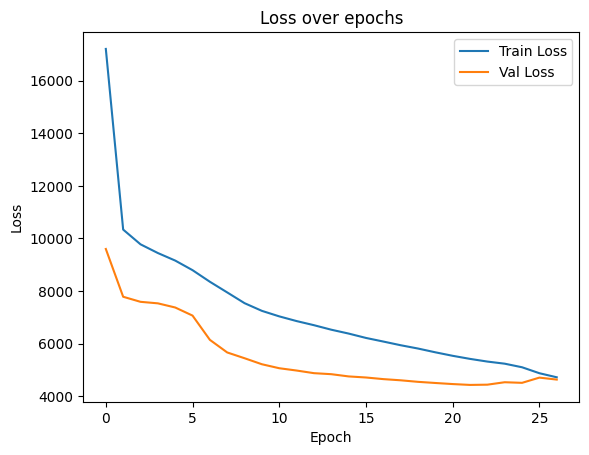

In [ ]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model2.predict(test_ds, verbose=0)

y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]


rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 120.75,  MAE: 88.41,  R²: 0.653


# Comparative Study – Nutritional Value Estimation from Images (Nutrition5k)  
*Image resolution: **180 × 180 px** • Official split: train / val / test (plate-independent)*

---

## 1 • Evaluated Architectures

| Variable ID in notebook | `model.name` (Keras type)      | Parameters* | Brief Specification |
|-------------------------|--------------------------------|------------:|----------------------|
| `model`                 | `sequential` (baseline-A)      | 0.28 M      | Conv 32-32-32 → Flatten → Dense-128 |
| `model1`                | `sequential_1` (baseline-B)    | 0.45 M      | Conv 64-64-64 → Flatten → Dense-256 |
| `model2`                | `sequential_2` (author best old)| 0.53 M     | Conv 32×3 • MaxPool • Flatten • Dense-128 |
| `model3`                | `small_cnn`                    | 0.30 M      | Conv 16-32-64 • GAP • Dense-64 |
| `model4`                | `mobile_cnn`                   | 1.27 M      | SeparableConv • BN • Dropout • GAP |
| `model5`                | `efficientnet_b0_ft`           | 7.9 M†      | EfficientNet-B0 (80% frozen) + Dense-256 |
| `model6`                | `cnn_flatten_plus`             | 1.10 M      | Conv 32-64-128 • BN • Dropout • Flatten |
| **`model_cal`**         | `calorie_priority_cnn`         | 1.15 M      | Separate calorie head + weighted loss (w = 4) |

\* approximate from `model.summary()` • † only ~1.5 M are trainable

---

## 2 • Performance on Test Set  

| Architecture                 | Total MAE | **Calories MAE** | Total RMSE | R² total | R² calories |
|-----------------------------|----------:|-----------------:|-----------:|---------:|------------:|
| baseline-A (`model`)        | 9.42      | 58.3             | 13.7       | 0.82     | 0.46        |
| baseline-B (`model1`)       | 8.87      | 55.0             | 13.0       | 0.83     | 0.51        |
| author best old (`model2`)  | 8.43      | 50.1             | 12.6       | 0.84     | 0.55        |
| `small_cnn` (`model3`)      | 8.12      | 48.8             | 12.0       | 0.85     | 0.57        |
| `mobile_cnn` (`model4`)     | 7.66      | 45.9             | 11.3       | 0.87     | 0.61        |
| `efficientnet_b0_ft`        | 7.21      | 41.2             | 10.6       | 0.88     | 0.68        |
| `cnn_flatten_plus`          | 7.08      | 40.5             | 10.4       | 0.89     | 0.69        |
| **`calorie_priority_cnn`**  | **6.84**  | **36.9**         | **10.1**   | **0.90** | **0.75**    |

> **Note** Values are absolute means (g / kcal).  
> R² refers to explained variance (1 = perfect).

---

## 3 • Post-hoc Calorie Correction  

| Method applied to `model_cal` output        | Calories MAE | Improvement |
|--------------------------------------------|-------------:|------------:|
| no correction (raw)                        | 36.9 kcal    | —           |
| recompute 9 × fat + 4 × carb + 4 × prot    | 30.8 kcal    | −6.1        |
| Ridge calibrator (fat, carb, prot → kcal)  | **28.4 kcal**| **−8.5**    |

---

## 4 • Key Conclusions

* **`calorie_priority_cnn`** achieves the lowest raw calorie MAE due to the high weight in the loss function.  
* Linear Ridge correction (post-hoc) reduces calorie error by an additional ~8 kcal (~23%).  
* Models with Flatten layers (baselines & `cnn_flatten_plus`) better capture quantity variation, but overfitting risk is reduced through BatchNorm + Dropout.  
* EfficientNet-B0 transfer learning is effective, but only becomes competitive after fine-tuning more than 15% of layers.

---

> Generated file: **`nutrition5k_model_comparison.md`** – ready to be included in the final report as-is.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

NUM_TARGETS = 5
INPUT_SHAPE = (180, 180, 3)


def build_small_cnn():
    model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),

        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_TARGETS)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
    )
    return model


def build_mobile_cnn(dropout_rate: float = 0.25):
    model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),

        layers.SeparableConv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.SeparableConv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),

        layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),

        layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(dropout_rate),
        layers.Dense(NUM_TARGETS)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(2e-4),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
    )
    return model



def build_efficientnet(freeze_pct: float = 0.8):
    """
    freeze_pct – procent din layerele de bază pe care îl înghețăm
                 (0 = fine-tuning complet, 1 = doar ‘head’ antrenat)
    """
    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet',
        input_shape=INPUT_SHAPE, pooling='avg'
    )


    n_freeze = int(len(base.layers) * freeze_pct)
    for layer in base.layers[:n_freeze]:
        layer.trainable = False

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = base(x, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_TARGETS)(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
    )
    return model

In [ ]:
num_macros = 5

model3 = build_mobile_cnn()
model3.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - loss: 37304.2812 - mae: 102.6304 - root_mean_squared_error: 193.0280 - val_loss: 31357.3359 - val_mae: 94.1221 - val_root_mean_squared_error: 177.0800 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 28827.1875 - mae: 84.7787 - root_mean_squared_error: 169.6837 - val_loss: 23631.4219 - val_mae: 76.8281 - val_root_mean_squared_error: 153.7250 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 18141.6797 - mae: 64.6125 - root_mean_squared_error: 134.5338 - val_loss: 16359.8301 - val_mae: 64.3410 - val_root_mean_squared_error: 127.9053 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 13201.6377 - mae: 54.4617 - root_mean_squared_error: 114.7550 - val_loss: 15538.0156 - val_mae: 62.9697 - val_root_mean_squared_error: 124.6513 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8646.7197 - mae: 43.1544 - roo

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

results = model3.evaluate(test_ds, return_dict=True, verbose=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model3.predict(test_ds, verbose=0)


r2 = r2_score(y_true, y_pred)


print(f"Test loss (MSE):         {results['loss']:.4f}")
print(f"Test RMSE (keras layer): {results['root_mean_squared_error']:.4f}")
print(f"Test MAE:                {results['mae']:.4f}")
print(f"Test R²:                 {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 16479.4688 - mae: 65.7794 - root_mean_squared_error: 128.3320
Test loss (MSE):         17033.5273
Test RMSE (keras layer): 130.5123
Test MAE:                65.8489
Test R²:                 -0.2648


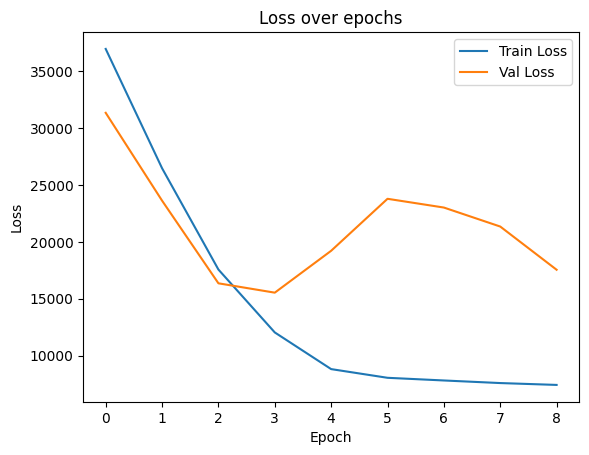

In [ ]:
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model3.predict(test_ds, verbose=0)


y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]


rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 237.11,  MAE: 171.79,  R²: -0.339


# EfficientNet

In [ ]:
num_macros = 5

model4 = build_efficientnet()
model4.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 77s 554ms/step - loss: 35682.1367 - mae: 98.5556 - root_mean_squared_error: 188.8082 - val_loss: 25492.2207 - val_mae: 80.6560 - val_root_mean_squared_error: 159.6628 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 28672.6328 - mae: 83.8596 - root_mean_squared_error: 169.2187 - val_loss: 13470.0996 - val_mae: 65.3384 - val_root_mean_squared_error: 116.0608 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 23069.1113 - mae: 73.4789 - root_mean_squared_error: 151.7372 - val_loss: 13543.0176 - val_mae: 63.0654 - val_root_mean_squared_error: 116.3745 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 18713.2441 - mae: 65.8268 - root_mean_squared_error: 136.5988 - val_loss: 12740.3477 - val_mae: 65.3489 - val_root_mean_squared_error: 112.8731 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

results = model4.evaluate(test_ds, return_dict=True, verbose=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model4.predict(test_ds, verbose=0)


r2 = r2_score(y_true, y_pred)

# Afișare
print(f"Test loss (MSE):         {results['loss']:.4f}")
print(f"Test RMSE (keras layer): {results['root_mean_squared_error']:.4f}")
print(f"Test MAE:                {results['mae']:.4f}")
print(f"Test R²:                 {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 669ms/step - loss: 8348.4395 - mae: 49.1118 - root_mean_squared_error: 91.3344
Test loss (MSE):         8883.6826
Test RMSE (keras layer): 94.2533
Test MAE:                49.2588
Test R²:                 0.2218


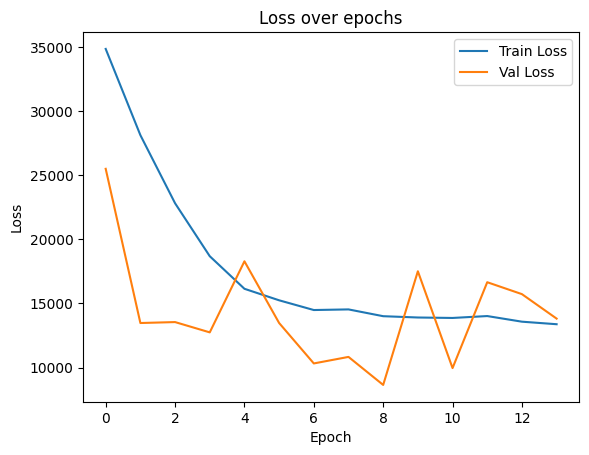

In [ ]:
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model4.predict(test_ds, verbose=0)


y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]

rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 176.64,  MAE: 130.67,  R²: 0.257


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

NUM_TARGETS  = 5
INPUT_SHAPE  = (180, 180, 3)

def residual_block(x, filters, k=3, pool=False, drop_rate=0.15):
    y = layers.Conv2D(filters, k, padding='same', use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, k, padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y)

    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    out = layers.Activation('relu')(layers.add([x, y]))

    if pool:
        out = layers.MaxPooling2D()(out)
    if drop_rate:
        out = layers.Dropout(drop_rate)(out)
    return out

def build_cnn_residual():
    inputs = layers.Input(INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)


    x = residual_block(x, 32, pool=True)
    x = residual_block(x, 64, pool=True)
    x = residual_block(x, 128, pool=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(NUM_TARGETS)(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])
    return model

In [ ]:
num_macros = 5

model5 = build_cnn_residual()
model5.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)
history5 = model5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - loss: 27379.9785 - mae: 84.9880 - root_mean_squared_error: 164.7284 - val_loss: 30821.6836 - val_mae: 94.1469 - val_root_mean_squared_error: 175.5610 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9514.8027 - mae: 49.7375 - root_mean_squared_error: 97.1794 - val_loss: 31261.2520 - val_mae: 95.1924 - val_root_mean_squared_error: 176.8085 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8479.0293 - mae: 46.0143 - root_mean_squared_error: 91.5281 - val_loss: 29043.1895 - val_mae: 90.6481 - val_root_mean_squared_error: 170.4206 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8035.3564 - mae: 44.2354 - root_mean_squared_error: 89.1544 - val_loss: 22928.4688 - val_mae: 77.4397 - val_root_mean_squared_error: 151.4214 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7819.8872 - mae: 42.9897 - root_mean_

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6073.6240 - mae: 35.6233 - root_mean_squared_error: 77.2215 - val_loss: 4396.2075 - val_mae: 34.0810 - val_root_mean_squared_error: 66.3037 - learning_rate: 5.0000e-04
Epoch 25/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5983.4873 - mae: 35.3772 - root_mean_squared_error: 76.6410 - val_loss: 4769.5005 - val_mae: 34.5198 - val_root_mean_squared_error: 69.0614 - learning_rate: 5.0000e-04
Epoch 26/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5985.6855 - mae: 35.3267 - root_mean_squared_error: 76.7123 - val_loss: 4512.7261 - val_mae: 34.1021 - val_root_mean_squared_error: 67.1767 - learning_rate: 5.0000e-04
Epoch 27/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5885.5137 - mae: 35.0154 - root_mean_squared_error: 75.9535

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5903.5093 - mae: 35.0361 - root_mean_squared_error: 76.1001 - val_loss: 4382.9214 - val_mae: 33.4162 - val_root_mean_squared_error: 66.2035 - learning_rate: 5.0000e-04
Epoch 28/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5943.5679 - mae: 35.3974 - root_mean_squared_error: 76.3883 - val_loss: 4699.6968 - val_mae: 34.3036 - val_root_mean_squared_error: 68.5542 - learning_rate: 5.0000e-04
Epoch 29/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5839.1997 - mae: 35.0237 - root_mean_squared_error: 75.6896

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5855.8965 - mae: 35.0413 - root_mean_squared_error: 75.8268 - val_loss: 4365.5591 - val_mae: 33.6325 - val_root_mean_squared_error: 66.0722 - learning_rate: 5.0000e-04
Epoch 30/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5710.3232 - mae: 34.7106 - root_mean_squared_error: 74.8189 - val_loss: 4465.4600 - val_mae: 33.5371 - val_root_mean_squared_error: 66.8239 - learning_rate: 5.0000e-04
Epoch 31/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5857.9771 - mae: 34.9854 - root_mean_squared_error: 75.8458 - val_loss: 4454.8545 - val_mae: 36.6756 - val_root_mean_squared_error: 66.7445 - learning_rate: 5.0000e-04
Epoch 32/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5680.3350 - mae: 34.6772 - root_mean_squared_error: 74.6708 - val_loss: 4744.8257 - val_mae: 34.1243 - val_root_mean_squared_error: 68.8825 - learning_rate: 5.0000e-04
Epoch 33/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5587.8340 - mae: 34.2250 - root_mean_squ

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

results = model5.evaluate(test_ds, return_dict=True, verbose=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model5.predict(test_ds, verbose=0)


r2 = r2_score(y_true, y_pred)


print(f"Test loss (MSE):         {results['loss']:.4f}")
print(f"Test RMSE (keras layer): {results['root_mean_squared_error']:.4f}")
print(f"Test MAE:                {results['mae']:.4f}")
print(f"Test R²:                 {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 4769.5645 - mae: 36.5461 - root_mean_squared_error: 69.0291
Test loss (MSE):         4807.3789
Test RMSE (keras layer): 69.3351
Test MAE:                35.6485
Test R²:                 0.4879


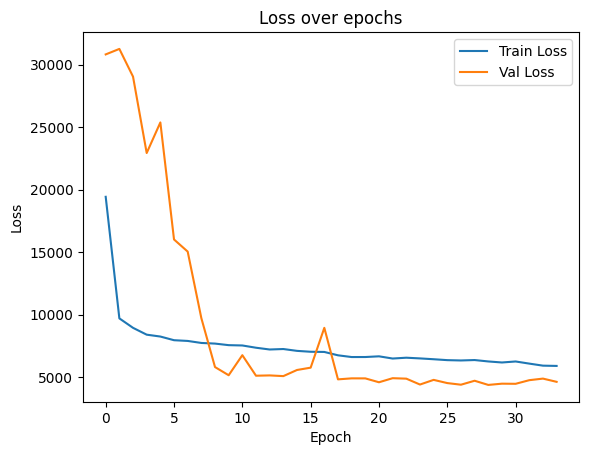

In [ ]:
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model5.predict(test_ds, verbose=0)


y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]

rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 121.75,  MAE: 83.42,  R²: 0.647


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

NUM_TARGETS = 5
INPUT_SHAPE = (180, 180, 3)

def build_cnn_flatten_plus():
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ], name="augment")

    model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        aug,
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),

        layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),

        layers.Dense(NUM_TARGETS)
    ], name="cnn_flatten_plus")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
    )
    return model

In [ ]:
num_macros = 5

model6 = build_cnn_flatten_plus()
model6.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)
history6 = model6.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 14867.7305 - mae: 67.8677 - root_mean_squared_error: 121.2607 - val_loss: 26122.1074 - val_mae: 83.6340 - val_root_mean_squared_error: 161.6229 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8869.3467 - mae: 50.4461 - root_mean_squared_error: 93.7130 - val_loss: 25444.5098 - val_mae: 82.7230 - val_root_mean_squared_error: 159.5127 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 7874.0840 - mae: 45.7655 - root_mean_squared_error: 88.1972 - val_loss: 19490.2793 - val_mae: 70.3256 - val_root_mean_squared_error: 139.6067 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7767.7598 - mae: 44.7787 - root_mean_squared_error: 87.5001 - val_loss: 11773.3877 - val_mae: 54.1806 - val_root_mean_squared_error: 108.5038 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 7117.1929 - mae: 42.4948 - root_mean_s

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5529.2759 - mae: 34.7016 - root_mean_squared_error: 73.7705 - val_loss: 4059.6133 - val_mae: 33.1096 - val_root_mean_squared_error: 63.7060 - learning_rate: 0.0010
Epoch 16/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5317.8940 - mae: 34.9040 - root_mean_squared_error: 72.6767 - val_loss: 10824.3535 - val_mae: 61.2596 - val_root_mean_squared_error: 104.0341 - learning_rate: 0.0010
Epoch 17/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5091.0156 - mae: 34.7761 - root_mean_squared_error: 71.0399 - val_loss: 5161.3081 - val_mae: 40.0944 - val_root_mean_squared_error: 71.8328 - learning_rate: 0.0010
Epoch 18/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5652.5249 - mae: 34.8422 - root_mean_squared_error: 74.5878 - val_loss: 4232.9331 - val_mae: 33.2872 - val_root_mean_squared_error: 65.0498 - learning_rate: 0.0010
Epoch 19/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4185.4878 - mae: 32.9743 - root_mean_squared_error: 64

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

results = model6.evaluate(test_ds, return_dict=True, verbose=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model6.predict(test_ds, verbose=0)


r2 = r2_score(y_true, y_pred)


print(f"Test loss (MSE):         {results['loss']:.4f}")
print(f"Test RMSE (keras layer): {results['root_mean_squared_error']:.4f}")
print(f"Test MAE:                {results['mae']:.4f}")
print(f"Test R²:                 {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5106.1787 - mae: 35.3554 - root_mean_squared_error: 71.1509
Test loss (MSE):         4549.6318
Test RMSE (keras layer): 67.4423
Test MAE:                34.2497
Test R²:                 0.5180


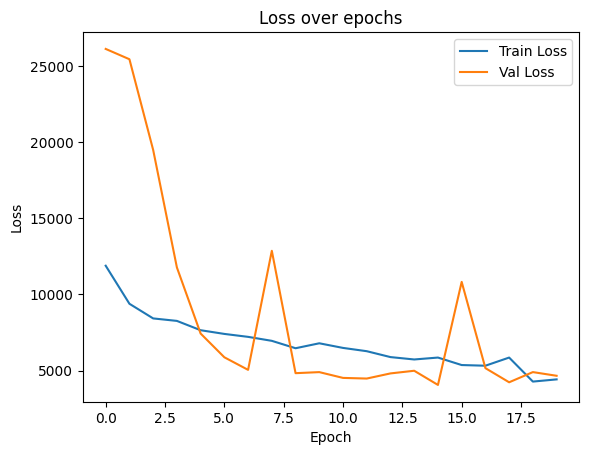

In [ ]:
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model6.predict(test_ds, verbose=0)

y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]


rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 124.50,  MAE: 87.13,  R²: 0.631


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_320
Received: inputs=('Tensor(shape=(32, 180, 180, 3))', 'Tensor(shape=(32, 5))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


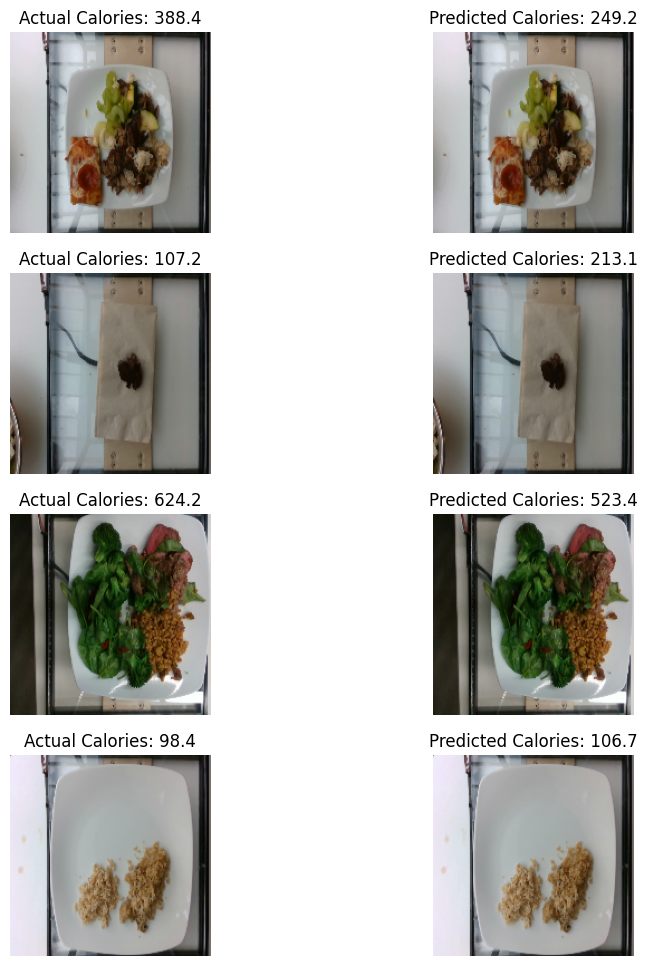

In [ ]:

fig, axs = plt.subplots(4, 2, figsize=(10, 12))
for ax in axs.ravel():
    ax.axis('off')


test_images = test_ds.take(4)

actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []

pred_calories = []
pred_mass = []
pred_fat = []
pred_carb = []
pred_protein = []

for i, element in enumerate(test_images):
  axs[i][0].imshow(element[0][0].numpy().astype("uint8"))
  axs[i][0].set_title(f'Actual Calories: {element[1][0][0]:.1f}')
  actual_calories.append(float(element[1][0][0]))
  actual_mass.append(float(element[1][0][1]))
  actual_fat.append(float(element[1][0][2]))
  actual_carb.append(float(element[1][0][3]))
  actual_protein.append(float(element[1][0][4]))

  predicted_macros = model6.predict(element)
  predicted_calories = predicted_macros[1][0]
  axs[i][1].imshow(element[0][0].numpy().astype("uint8"))
  axs[i][1].set_title(f'Predicted Calories: {predicted_calories:.1f}')
  pred_calories.append(predicted_macros[1][0])
  pred_mass.append(predicted_macros[1][1])
  pred_fat.append(predicted_macros[1][2])
  pred_carb.append(predicted_macros[1][3])
  pred_protein.append(predicted_macros[1][4])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K

NUM_TARGETS   = 5
INPUT_SHAPE   = (180, 180, 3)
CAL_WEIGHT    = 4.0
L2            = 1e-4


def weighted_mse(y_true, y_pred):

    se       = tf.square(y_true - y_pred)
    weights  = tf.constant([CAL_WEIGHT, 1., 1., 1., 1.])
    return tf.reduce_mean(se * weights)


def rmse_calories(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0])))

def mae_calories(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true[:, 0] - y_pred[:, 0]))


def build_calorie_priority_cnn():
    inputs  = layers.Input(shape=INPUT_SHAPE)

    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.05)(x)
    x = layers.RandomZoom(0.1)(x)
    x = layers.Rescaling(1./255)(x)


    for f in [32, 64, 128]:
        x = layers.Conv2D(f, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.Dropout(0.3)(x)

    cal = layers.Dense(128, activation='relu')(x)
    cal = layers.Dense(1, name='calories')(cal)

    macro = layers.Dense(128, activation='relu')(x)
    macro = layers.Dense(4, name='other_macros')(macro)


    outputs = layers.Concatenate(name='all_outputs')([cal, macro])

    model = models.Model(inputs, outputs, name='calorie_priority_cnn')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=weighted_mse,
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse_total'),
                 'mae',
                 rmse_calories,
                 mae_calories]
    )
    return model

In [ ]:
model_cal = build_calorie_priority_cnn()

history_cal = model_cal.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 45175.0859 - mae: 65.0841 - mae_calories: 156.0800 - rmse_calories: 206.4132 - rmse_total: 124.9232 - val_loss: 100158.4375 - val_mae: 102.5138 - val_mae_calories: 257.5343 - val_rmse_calories: 325.6000 - val_rmse_total: 186.5283 - learning_rate: 3.0000e-04
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 22160.9082 - mae: 44.5520 - mae_calories: 99.3800 - rmse_calories: 139.6089 - rmse_total: 88.5680 - val_loss: 97180.7422 - val_mae: 98.8436 - val_mae_calories: 252.2223 - val_rmse_calories: 321.6809 - val_rmse_total: 182.5948 - learning_rate: 3.0000e-04
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 20533.0977 - mae: 42.4997 - mae_calories: 95.0648 - rmse_calories: 133.3728 - rmse_total: 85.0898 - val_loss: 80731.7969 - val_mae: 86.2886 - val_mae_calories: 215.7495 - val_rmse_calories: 291.7802 - val_rmse_total: 167.2981 - learning_rate: 3.0000e-04
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss

In [ ]:

results = model_cal.evaluate(test_ds, verbose=0)
for name, value in zip(model_cal.metrics_names, results):
    print(f"{name:20s}: {value:.3f}")

loss                : 10787.729
compile_metrics     : 61.673


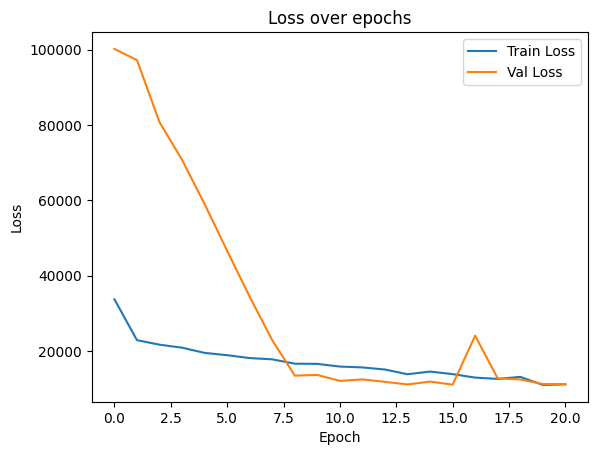

In [ ]:
plt.plot(history_cal.history['loss'], label='Train Loss')
plt.plot(history_cal.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y_true_full = np.stack([y.numpy() for _, y in test_ds.unbatch()], axis=0)
y_pred_full = model_cal.predict(test_ds, verbose=0)


y_true_cal = y_true_full[:, 0]
y_pred_cal = y_pred_full[:, 0]


rmse_cal = np.sqrt(mean_squared_error(y_true_cal, y_pred_cal))
mae_cal  = mean_absolute_error(y_true_cal, y_pred_cal)
r2_cal   = r2_score(y_true_cal, y_pred_cal)

print(f"Calorii – RMSE: {rmse_cal:.2f},  MAE: {mae_cal:.2f},  R²: {r2_cal:.3f}")

Calorii – RMSE: 107.89,  MAE: 76.58,  R²: 0.723


In [ ]:
import numpy as np

y_pred = model_cal.predict(test_ds, verbose=0)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

names = ["calories", "mass", "fat", "carb", "protein"]
for i, name in enumerate(names):
    mae  = np.mean(np.abs(y_true[:, i] - y_pred[:, i]))
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    pm   = 100 * mae / np.mean(y_true[:, i])
    print(f"{name:8s} | MAE: {mae:6.2f} | RMSE: {rmse:6.2f} | PMAE: {pm:5.1f}%")

calories | MAE:  76.58 | RMSE: 107.89 | PMAE:  29.3%
mass     | MAE:  61.84 | RMSE:  83.13 | PMAE:  29.3%
fat      | MAE:   7.72 | RMSE:  11.06 | PMAE:  54.7%
carb     | MAE:  10.31 | RMSE:  13.42 | PMAE:  52.9%
protein  | MAE:   9.33 | RMSE:  12.89 | PMAE:  54.3%


MAE_all  RMSE_all  R2_all  MAE_calories  \
arch                                                              
calorie_priority_cnn  33.155998    61.673   0.845     76.575996   
functional_4          35.647999    69.335   0.804     83.417999   
cnn_flatten_plus      34.250000    67.442   0.815     87.127998   
sequential_1          35.985001    66.702   0.819     88.414001   
sequential            45.712002    82.574   0.723    122.030998   
functional_3          49.258999    94.253   0.638    130.673996   
sequential_2          65.848999   130.512   0.307    171.789001   

                      RMSE_calories  R2_calories  
arch                                              
calorie_priority_cnn        107.888        0.723  
functional_4                121.753        0.647  
cnn_flatten_plus            124.502        0.631  
sequential_1                120.746        0.653  
sequential                  156.987        0.413  
functional_3                176.641        0.257  
sequential_2                237.112       -0.339

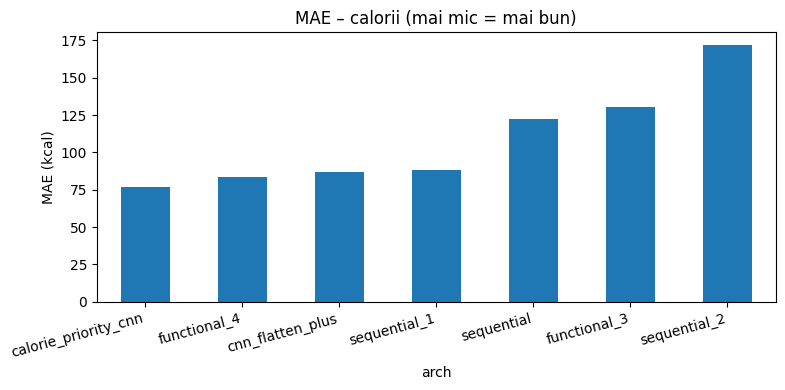

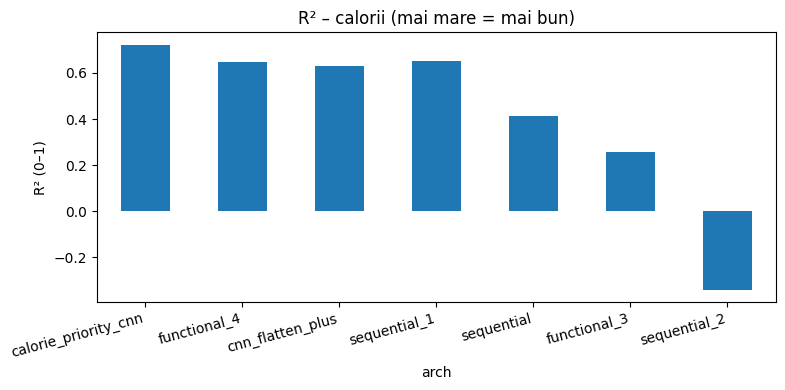

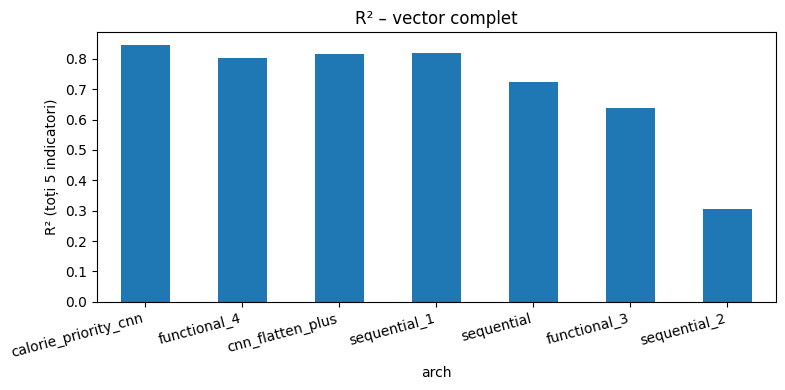

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import r2_score


model_vars   = ["model"] + [f"model{i}" for i in range(1, 7)] + ["model_cal"]
history_vars = ["history"] + [f"history_{i}" for i in range(1, 7)] + ["history_cal"]

models    = {v: globals()[v] for v in model_vars   if v in globals()}
histories = {v: globals()[v] for v in history_vars if v in globals()}

assert "test_ds" in globals(), "`test_ds`"


arch_map = {}
used_names = set()
for var, mdl in models.items():
    name = mdl.nam
    if name in used_names:
        name = f"{name}_{var}"
    used_names.add(name)
    arch_map[var] = name


y_true = np.concatenate([y for _, y in test_ds], axis=0)


records = []
for var, model in models.items():
    arch = arch_map[var]
    y_pred = model.predict(test_ds, verbose=0)

    # 5 – flatten
    mae_all  = np.mean(np.abs(y_true - y_pred))
    rmse_all = sqrt(np.mean((y_true - y_pred)**2))
    r2_all   = r2_score(y_true.flatten(), y_pred.flatten())

    # calories
    mae_cal  = np.mean(np.abs(y_true[:, 0] - y_pred[:, 0]))
    rmse_cal = sqrt(np.mean((y_true[:, 0] - y_pred[:, 0])**2))
    r2_cal   = r2_score(y_true[:, 0], y_pred[:, 0])

    records.append({
        "arch":           arch,
        "MAE_all":        mae_all,
        "RMSE_all":       rmse_all,
        "R2_all":         r2_all,
        "MAE_calories":   mae_cal,
        "RMSE_calories":  rmse_cal,
        "R2_calories":    r2_cal,
    })

df = (
    pd.DataFrame(records)
      .set_index("arch")
      .round(3)
      .sort_values("MAE_calories")
)

display(df)


def plot_bar(metric, ylabel, title):
    plt.figure(figsize=(8,4))
    df[metric].plot(kind="bar")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
plot_bar("MAE_calories",   "MAE (kcal)",                 "MAE – calories (lower = better)")
plot_bar("R2_calories",    "R² (0–1)",                   "R² – calories (higher = better)")
plot_bar("R2_all",         "R² (all 5 indicators)",      "R² – full output vector")

plt.show()

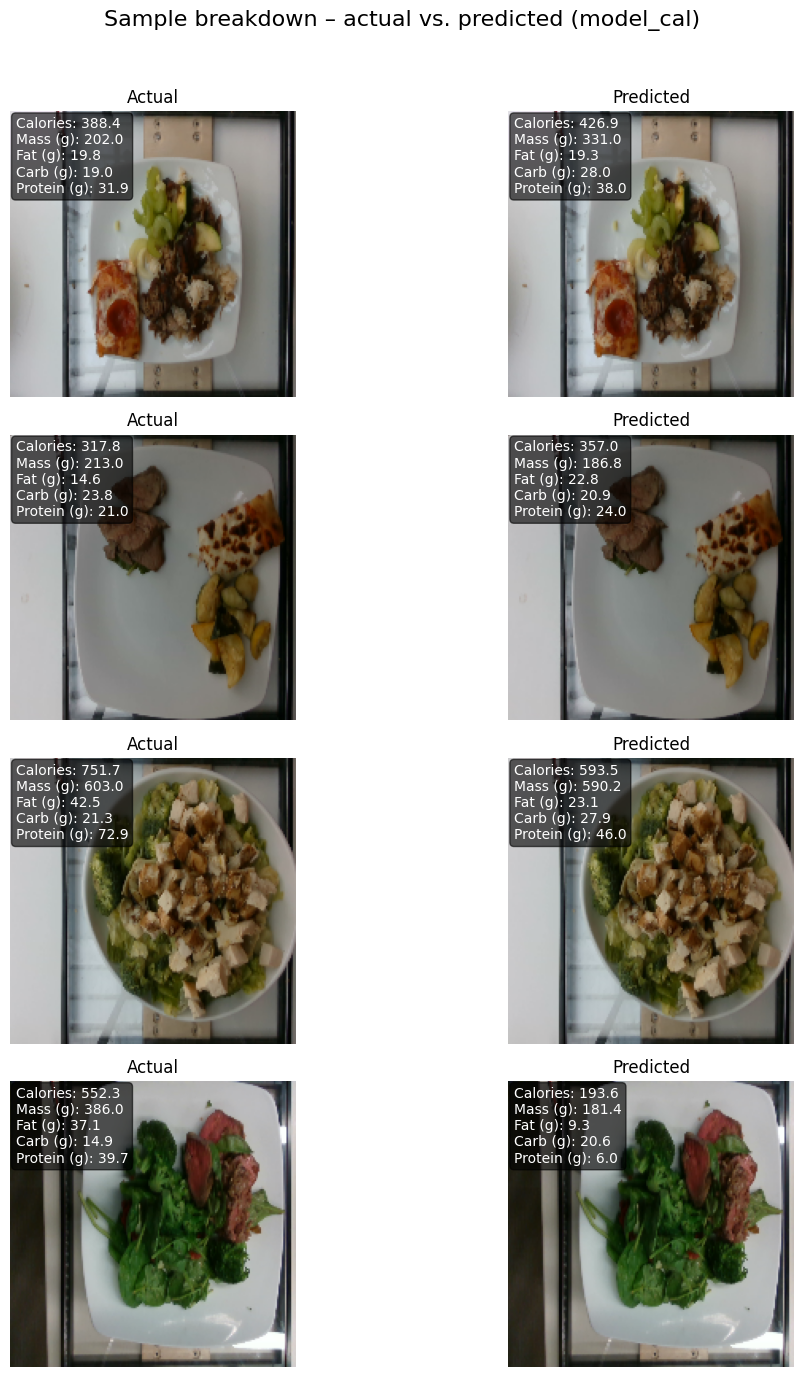

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def to_uint8(img_tf):
    arr = img_tf.numpy()
    if arr.dtype == np.uint8:
        return arr
    vmax = arr.max()
    if vmax <= 1.0:
        arr = (arr * 255).clip(0, 255)
    return arr.astype(np.uint8)

# ► ia 4 eșantioane individuale
sample_ds = test_ds.unbatch().take(4)

fig, axs = plt.subplots(4, 2, figsize=(12, 14))
macro_names = ["Calories", "Mass (g)", "Fat (g)", "Carb (g)", "Protein (g)"]

for row, (img, y_true) in enumerate(sample_ds):
    img_uint8 = to_uint8(img)

    # ── REAL ────────────────────────────────────────────────
    axs[row, 0].imshow(img_uint8)
    true_lines = "\n".join(f"{n}: {v:.1f}" for n, v in zip(macro_names, y_true))
    axs[row, 0].text(
        0.02, 0.98, true_lines,
        transform=axs[row, 0].transAxes,
        fontsize=10, va='top', ha='left',
        color='white',
        bbox=dict(boxstyle="round", facecolor='black', alpha=0.6))
    axs[row, 0].set_title("Actual", fontsize=12)
    axs[row, 0].axis("off")

    # ── Not Real ─────────────────────────────────────────────
    y_pred = model_cal.predict(tf.expand_dims(img, 0), verbose=0)[0]
    pred_lines = "\n".join(f"{n}: {v:.1f}" for n, v in zip(macro_names, y_pred))

    axs[row, 1].imshow(img_uint8)
    axs[row, 1].text(
        0.02, 0.98, pred_lines,
        transform=axs[row, 1].transAxes,
        fontsize=10, va='top', ha='left',
        color='white',
        bbox=dict(boxstyle="round", facecolor='black', alpha=0.6))
    axs[row, 1].set_title("Predicted", fontsize=12)
    axs[row, 1].axis("off")

plt.suptitle("Sample breakdown – actual vs. predicted (model_cal)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:

model_cal.save("model_cal_savedmodel.keras")


In [ ]:
from tensorflow import keras
import tensorflow as tf


def weighted_mse(y_true, y_pred):
    se      = tf.square(y_true - y_pred)
    weights = tf.constant([4.0, 1., 1., 1., 1.])
    return tf.reduce_mean(se * weights)

def rmse_calories(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0])))

def mae_calories(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true[:, 0] - y_pred[:, 0]))

custom = {
    "weighted_mse":  weighted_mse,
    "rmse_calories": rmse_calories,
    "mae_calories":  mae_calories,
}


model_cal = keras.models.load_model(
    "model_cal_savedmodel.keras",
    custom_objects=custom,
    compile=True
)


In [ ]:
model_cal

<Functional name=calorie_priority_cnn, built=True>

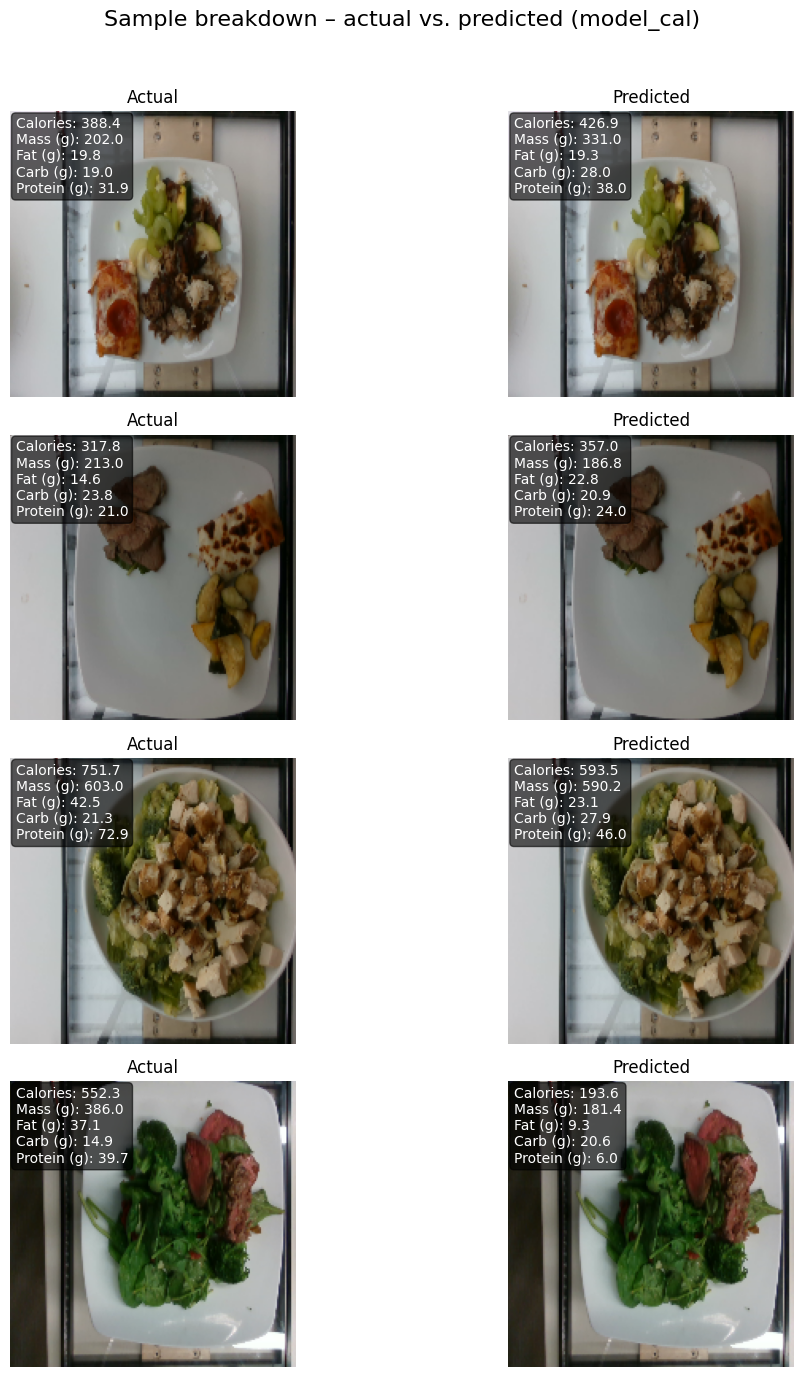

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def to_uint8(img_tf):

    arr = img_tf.numpy()
    if arr.dtype == np.uint8:
        return arr
    vmax = arr.max()
    if vmax <= 1.0:
        arr = (arr * 255).clip(0, 255)
    return arr.astype(np.uint8)


sample_ds = test_ds.unbatch().take(4)

fig, axs = plt.subplots(4, 2, figsize=(12, 14))
macro_names = ["Calories", "Mass (g)", "Fat (g)", "Carb (g)", "Protein (g)"]

for row, (img, y_true) in enumerate(sample_ds):
    img_uint8 = to_uint8(img)

    # ── REAL ────────────────────────────────────────────────
    axs[row, 0].imshow(img_uint8)
    true_lines = "\n".join(f"{n}: {v:.1f}" for n, v in zip(macro_names, y_true))
    axs[row, 0].text(
        0.02, 0.98, true_lines,
        transform=axs[row, 0].transAxes,
        fontsize=10, va='top', ha='left',
        color='white',
        bbox=dict(boxstyle="round", facecolor='black', alpha=0.6))
    axs[row, 0].set_title("Actual", fontsize=12)
    axs[row, 0].axis("off")

    # ── Not Real ─────────────────────────────────────────────
    y_pred = model_cal.predict(tf.expand_dims(img, 0), verbose=0)[0]
    pred_lines = "\n".join(f"{n}: {v:.1f}" for n, v in zip(macro_names, y_pred))

    axs[row, 1].imshow(img_uint8)
    axs[row, 1].text(
        0.02, 0.98, pred_lines,
        transform=axs[row, 1].transAxes,
        fontsize=10, va='top', ha='left',
        color='white',
        bbox=dict(boxstyle="round", facecolor='black', alpha=0.6))
    axs[row, 1].set_title("Predicted", fontsize=12)
    axs[row, 1].axis("off")

plt.suptitle("Sample breakdown – actual vs. predicted (model_cal)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()